# A/B Testing - Result Analytics and Prediction


It is output of an automated A/B testing for a worldwide e-commerce site. 

The Spain-based users have a much higher conversion rate than any other Spanish-speaking country. Since all Spanish speaking countries had the same translation of the site which was written by a Spaniard, it might be caused by translation. It is going to carry out a test where each country would have its one translation written by a local. However, the test draws that the new version does not make any change and even shows a worse impact than the old version does.

So, in the following, I am going to:

- check whether the test localized translation version really makes no impact;
- search out the reason for negative result, or for mistakingly draws such a negative result;
- develop an algorithm to confirm the result is truely negative, or avoid such a mistake.


__Data:__

- user_id : the id of the user. Unique by user. Can be joined to user id in the other table. For each user, we just check whether conversion happens the first time they land on the site since the test started.
- date : when they came to the site for the first time since the test started
- source : marketing channel: Ads, SEO, Direct . Direct means everything except for ads and SEO. Such as directly typing site URL on the browser, downloading the app w/o coming from SEO or Ads, referral friend, etc.
- device : device used by the user. It can be mobile or web
- browser_language : in browser or app settings, the language chosen by the user. It can be EN, ES, Other (Other means any language except for English and Spanish)
- ads_channel : if marketing channel is ads, this is the site where the ad was displayed. It
- can be: Google, Facebook, Bing, Yahoo ,Other. If the user didn't come via an ad, this field is NA
- browser : user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_App, Safari, Opera
- conversion : whether the user converted (1) or not (0). This is our label. A test is considered successful if it increases the proportion of users who convert.
- test : users are randomly split into test (1) and control (0). Test users see the new translation and control the old one. For Spain-based users, this is obviously always  since there is no change there.
- user_id : the id of the user. It can be joined to user id in the other table
- sex : user sex: Male or Female
- age : user age (self-reported)
- country : user country based on ip address


In [3]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
test = pd.read_csv('/Users/liuxuan/Desktop/未命名檔案夾 3/Xuan Liu Career/Data/DS Collection 资料/Spanish Translation A/Translation_Test/test_table.csv')
user = pd.read_csv('/Users/liuxuan/Desktop/未命名檔案夾 3/Xuan Liu Career/Data/DS Collection 资料/Spanish Translation A/Translation_Test/user_table.csv')

In [5]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [6]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [7]:
df = pd.merge(test, user, how = 'left')
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


### Confirm that the test is actually negative, i.e. Spain performed better

In [8]:
# check and confirm Spain converts more than other LatAm countries
df1 = df[df['test']==0][['country','conversion']].groupby('country').mean().sort_values(by = 'conversion', ascending = False)
df1 = df1.reset_index() # groupby(): should set 'country' as a column instead of a index
df1.head()

,country,conversion
0,Spain,0.079719
1,El Salvador,0.053554
2,Nicaragua,0.052647
3,Costa Rica,0.052256
4,Colombia,0.052089


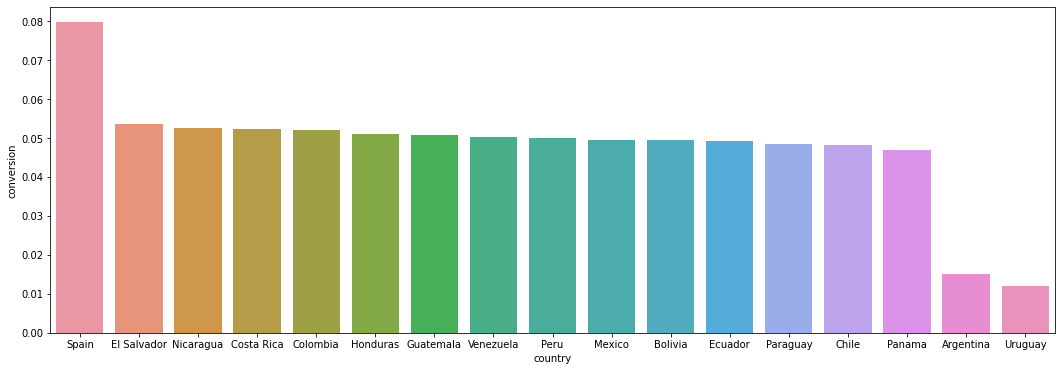

In [9]:
# Visualization
import seaborn as sns
fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(x='country', y='conversion', data=df1, ax = ax)
plt.show()

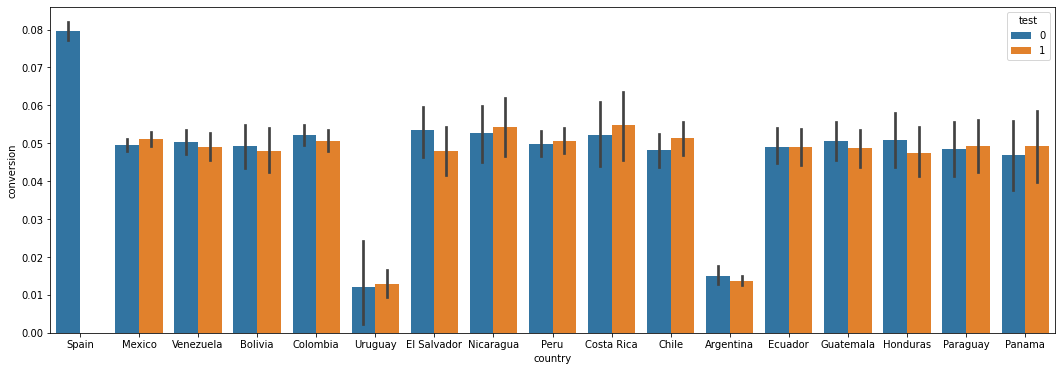

In [10]:
# Splitting by Test vs Control
fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(x = 'country', y = 'conversion', hue = 'test', data = df, ax = ax)
plt.show()

-- Indeed, Spain performs better than others.

### A/B Testing

In [11]:
df_test = df[df['country']!= 'Spain']
df_test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0,M,35.0,Mexico


In [12]:
from scipy import stats

In [13]:
p_value = stats.ttest_ind(df_test['conversion'][df_test['test']==1], df_test['conversion'][df_test['test']==0])

In [14]:
pd.DataFrame({'Test': [df_test['conversion'][df_test['test']==1].mean(), ''],
'Control': [df_test['conversion'][df_test['test']==0].mean(), p_value.pvalue]}, index = ['Mean of Convertions', 'p-value'])

,Test,Control
Mean of Convertions,0.0434247,4.833042e-02
p-value,,1.151447e-13


Mmh…not in the test are converting at 4.8% while users in the test just at 4.3%. That’s a 10% drop, which would be dramatic if it were true. The most likely reason for weird A/B test results are:
1. We didn’t collect enough data.
2. Some bias has been introduced in the experiment so that test/control people are not really random.

### Slicing by difference groups to identify randomrization

In [15]:
# Dataset by group: retrieve 'count' & 'mean'
def slicing_by(data, group):
    df_try = data.groupby([group,'test'])['conversion'].agg(["count","mean"])
    df_try = df_try.reset_index()
    return df_try

In [16]:
# Visualization by group
def slicing_visual(data1, group):
    fig = plt.figure(figsize = (14,6)) 
    ax = fig.subplots(1, 2)
    fig.suptitle('Count & Mean of Conversion by'+' '+ str(group))
    sns.barplot(x = group, y = 'count', data = data1, hue = 'test', ax = ax[0])
    sns.barplot(x = group, y = 'mean', data = data1, hue = 'test', ax = ax[1])
    plt.show()

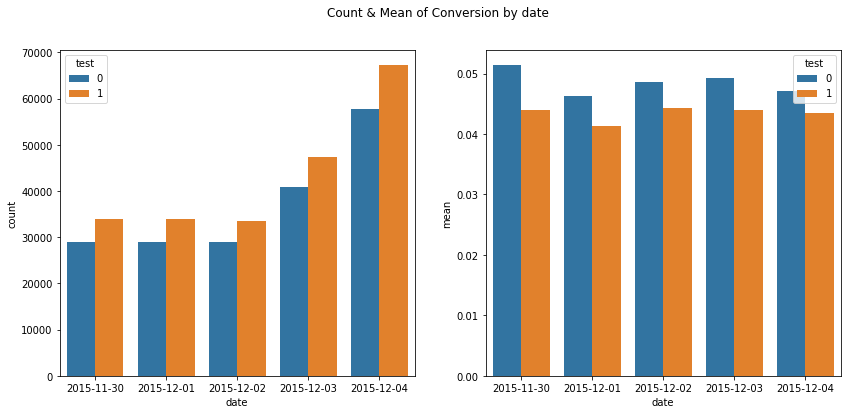

In [17]:
slicing_visual(slicing_by(df_test, group = 'date'), group = 'date')

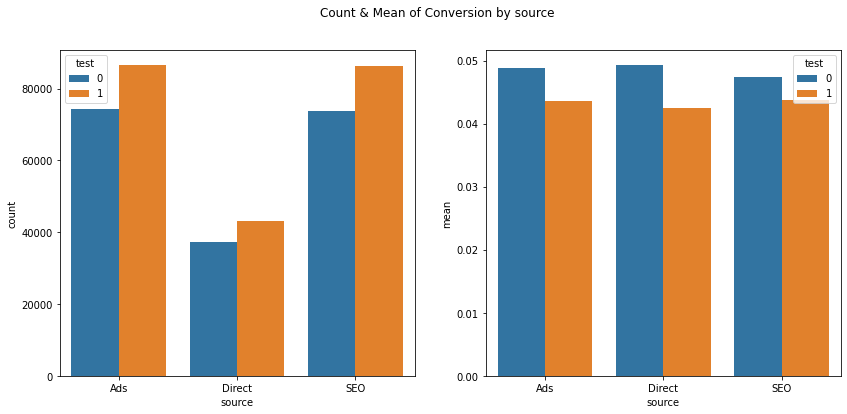

In [18]:
slicing_visual(slicing_by(df_test, group = 'source'), group = 'source')

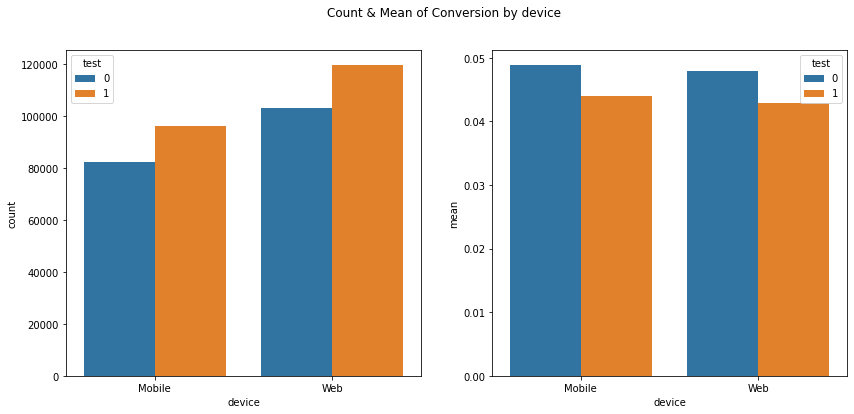

In [19]:
slicing_visual(slicing_by(df_test, group = 'device'), group = 'device')

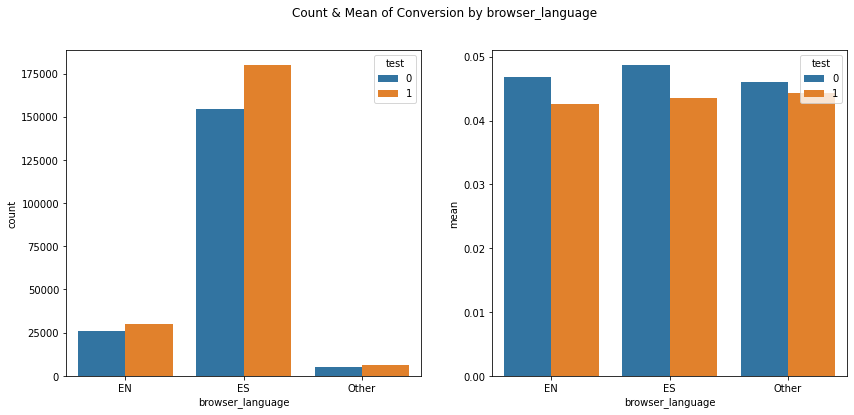

In [20]:
slicing_visual(slicing_by(df_test, group = 'browser_language'), group = 'browser_language')

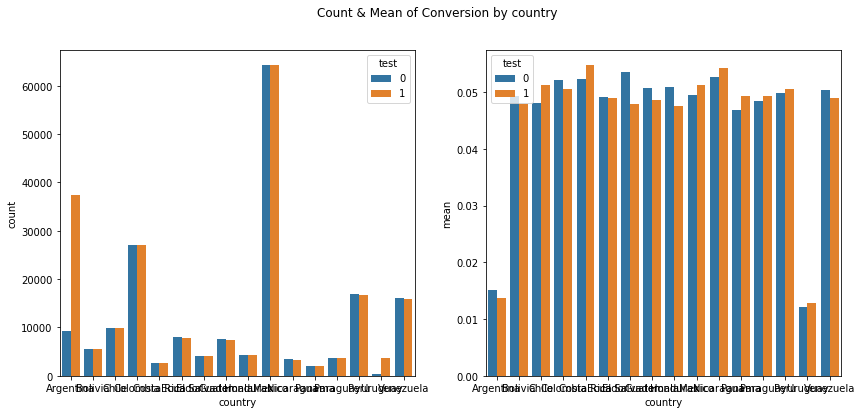

In [21]:
slicing_visual(slicing_by(df_test, group = 'country'), group = 'country')

All the test groups perform worse than control groups except country.
So, go in depth for country group

From the plot, we notice a couple of things:
1. Test has constantly been worse than control and there is relatively little variance across days. That
probably means that we do have enough data, but there was some bias in the experiment set up.
2. On a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to
capture weekly patterns, 2 weeks would be much better.

### Decision Tree

If randomization works, where the variables are the user dimensions and the outcome variable is whether the user is in test or control

In [22]:
from sklearn import tree
from sklearn.externals.six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data
from sklearn.tree import export_graphviz

/Users/liuxuan/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [28]:
df_test

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,0,1,1,2,3,0,1,M,21.0,9
3,290051,2015-12-03,0,0,2,1,0,0,1,F,22.0,9
4,548435,2015-11-30,0,1,1,2,2,0,1,M,19.0,9
5,540675,2015-12-03,1,0,1,5,0,0,1,F,22.0,15
6,863394,2015-12-04,2,0,2,5,0,0,0,M,35.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...
453315,783089,2015-12-02,0,0,1,0,0,0,0,F,20.0,9
453316,425010,2015-12-04,2,1,1,5,2,0,0,M,50.0,9
453317,826793,2015-12-01,2,0,1,5,0,0,1,F,20.0,3
453319,785224,2015-12-04,2,0,1,5,0,0,1,M,21.0,3


In [56]:
# Transform from string to encoding float

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in ['source','device','browser_language','ads_channel','browser','country','sex']:
    le.fit(df_test[col].astype(str))
    df_test[col] = le.transform(df_test[col].astype(str))


/Users/liuxuan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [69]:
features = ['source','device','browser_language','ads_channel','browser','sex','age','country']
target = 'test'
df_test = df_test.dropna()
X = df_test[['source','device','browser_language','ads_channel','browser','sex','age','country']]
y = df_test['test']

In [70]:
# Fit a Tree
dt = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 2)
dt.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

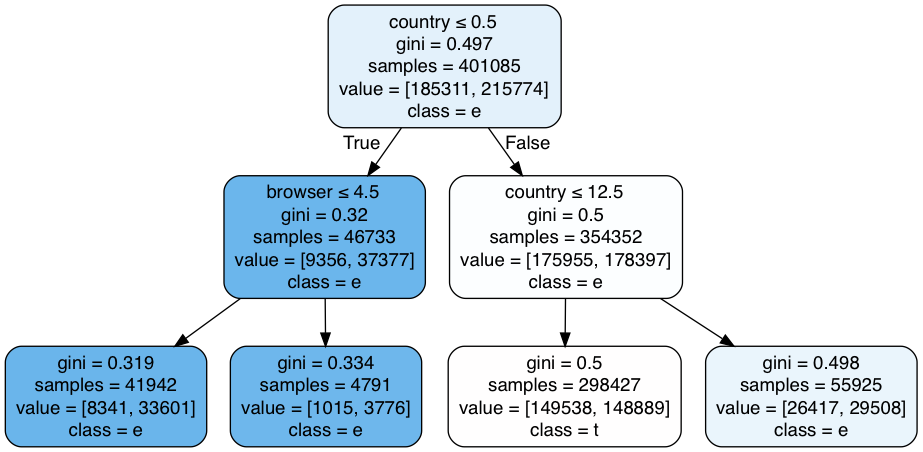

In [71]:
# Decision Tree Visualization
import sklearn.tree as tree
import pydotplus
from sklearn.externals.six import StringIO 
from IPython.display import Image
dot_data = StringIO()
tree.export_graphviz(dt, 
 out_file=dot_data, 
 class_names=target, # the target names.
 feature_names=features, # the feature names.
 filled=True, # Whether to fill in the boxes with colours.
 rounded=True, # Whether to round the corners of the boxes.
 special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

In [437]:
# build a Random Forest Model
model = H2OGradientBoostingEstimator(ntrees= 2, max_depth=2)
model.train(x = feature, y = target, training_frame = h2o_df)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [315]:
model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1583963373671_1


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.23624158970390588
RMSE: 0.48604690072451434
LogLoss: 0.6652429686182143
Mean Per-Class Error: 0.3909108528764884
AUC: 0.6628848432730149
Gini: 0.3257696865460298
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4806787665224881: 


,0,1,Error,Rate
0,51782.0,185556.0,0.7818,(185556.0/237338.0)
1,0.0,215983.0,0.0,(0.0/215983.0)
Total,51782.0,401539.0,0.4093,(185556.0/453321.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4806788,0.6995152,1.0
max f2,0.4806788,0.8533700,1.0
max f0point5,0.4806788,0.5926633,1.0
max accuracy,0.5394044,0.5926551,0.0
max precision,0.5394044,0.8079108,0.0
max recall,0.4806788,1.0,1.0
max specificity,0.5394044,0.9588309,0.0
max absolute_mcc,0.4806788,0.3425719,1.0
max min_per_class_accuracy,0.4806788,0.2181783,1.0
max mean_per_class_accuracy,0.4806788,0.6090891,1.0


Gains/Lift Table: Avg response rate: 47.64 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.1122097,0.5394044,1.6957026,1.6957026,0.8079108,0.8079108,0.1902742,0.1902742,69.5702642,69.5702642
,2,0.8857719,0.4806788,1.0467494,1.1289588,0.4987196,0.5378880,0.8097258,1.0,4.6749366,12.8958831
,3,1.0,0.3868749,0.0,1.0,0.0,0.4764461,0.0,1.0,-100.0,0.0



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2020-03-11 15:04:46,0.061 sec,0.0,0.4994449,0.6920372,0.5,1.0,0.5235539
,2020-03-11 15:04:47,1.505 sec,1.0,0.4920716,0.6773186,0.6628848,1.6957026,0.4093258
,2020-03-11 15:04:48,2.102 sec,2.0,0.4860469,0.6652430,0.6628848,1.6957026,0.4093258


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
country,31720.3457031,1.0,1.0
user_id,0.0,0.0,0.0
date,0.0,0.0,0.0
source,0.0,0.0,0.0
device,0.0,0.0,0.0
browser_language,0.0,0.0,0.0
ads_channel,0.0,0.0,0.0
browser,0.0,0.0,0.0
sex,0.0,0.0,0.0
age,0.0,0.0,0.0


In [505]:
df_country_RF = df[(df['test']==1) & (df['country']!='Spain')].groupby(['country']).size() / df[df['country']!='Spain'].groupby(['country']).size()
pd.DataFrame({'Percentage of Test (%)':[x*100 for x in df_country_RF]}, index = [x for x in df_country_RF.index])

,Percentage of Test (%)
Argentina,79.979886
Bolivia,50.107875
Chile,50.078533
Colombia,49.892712
Costa Rica,49.896402
Ecuador,49.443221
El Salvador,49.749235
Guatemala,49.606612
Honduras,49.101307
Mexico,50.025684


Uruguay & Argentina have 80% test and 20% control

In [502]:
def country_splicing(data, countries):
    for country in countries:
        test_val = df[(df['country']==country) & (df['test']==1)]['conversion'].values
        control_val = df[(df['test']==0) & (df['country']==country)]['conversion'].values
        test_mean = test_val.mean()
        control_mean = control_val.mean()
        p_val = stats.ttest_ind(test_val, control_val, equal_var=False).pvalue
        print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country, test_mean, control_mean, p_val))
    

In [478]:
test_mean = []
control_mean = []
p_val = []
for country in countries:
        test_val = df[(df['country']==country) & (df['test']==1)]['conversion'].values
        control_val = df[(df['test']==0) & (df['country']==country)]['conversion'].values
        test_mean.append(test_val.mean())
        control_mean.append(control_val.mean())
        p_val.append(stats.ttest_ind(test_val, control_val, equal_var=False).pvalue)

In [517]:
pd.DataFrame({'Test Mean':test_mean, 
              'Control Mean':control_mean, 
              'p-value':p_val}, 
             index = [countries])

,Control Mean,Test Mean,p-value
Mexico,0.049495,0.051186,0.165544
Venezuela,0.050344,0.048978,0.573702
Bolivia,0.049369,0.047901,0.718885
Colombia,0.052089,0.050571,0.423719
Uruguay,0.012048,0.012907,0.879764
El Salvador,0.053554,0.047947,0.248127
Nicaragua,0.052647,0.054177,0.780400
Peru,0.049914,0.050604,0.771953
Costa Rica,0.052256,0.054738,0.687876
Chile,0.048107,0.051295,0.302848


#### By slicing the country, non significant. But at least, we konw that a localized translation did not make things worse.